# Inverting for the Seismic hum source spectra in the mHz band using vertical component auto-correlation

## Synthetic spectra

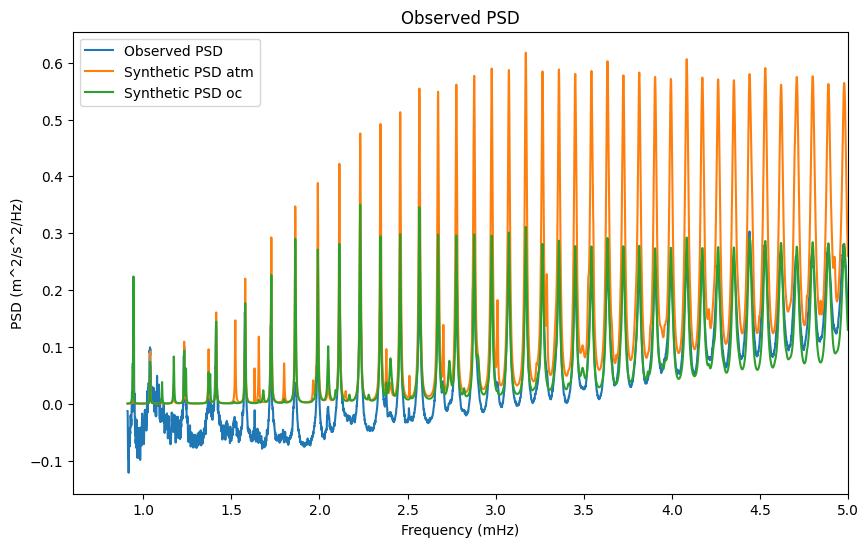

In [6]:
from functionsFitSPectrum import *
psd_stacked=np.load('InversionData/FinalResult_75.npy') # Load the stacked PSD data
len2 = 2**16
freqs= np.fft.fftfreq(2*len2-1,d=10) # 10s sampling time
freq_mask= (freqs >= 0.91 * 1e-3) & (freqs <= 5 * 1e-3) # 0.83mHz to 5mHz
params = [np.ones(len(psd_stacked[freq_mask])),np.ones(len(psd_stacked[freq_mask])),len2, freqs, freq_mask, psd_stacked] # alpha, Beta, len2, freqs, freq_mask, psd_stacked
args = [2.00576775e-21, 1.15965767e-17,  2.20839256e-25,  2.36300938e+00] # n1,n2,n3,n4
syntheticPSD,detrend_psd,syntheticPSD_atm,syntheticPSD_oc = GetSpectrum1(args,params)
fig,axes = plt.subplots(1,1,figsize=(10,6))
SimplePlot(axes,freqs[freq_mask],detrend_psd,label='Observed PSD')
SimplePlot(axes,freqs[freq_mask],syntheticPSD_atm,label='Synthetic PSD atm')
SimplePlot(axes,freqs[freq_mask],syntheticPSD_oc,label='Synthetic PSD oc')
plt.legend()
plt.savefig('Figures/ComparisonSyntheticsData.png',dpi=300)

### Plot of the stations used and the spectrum

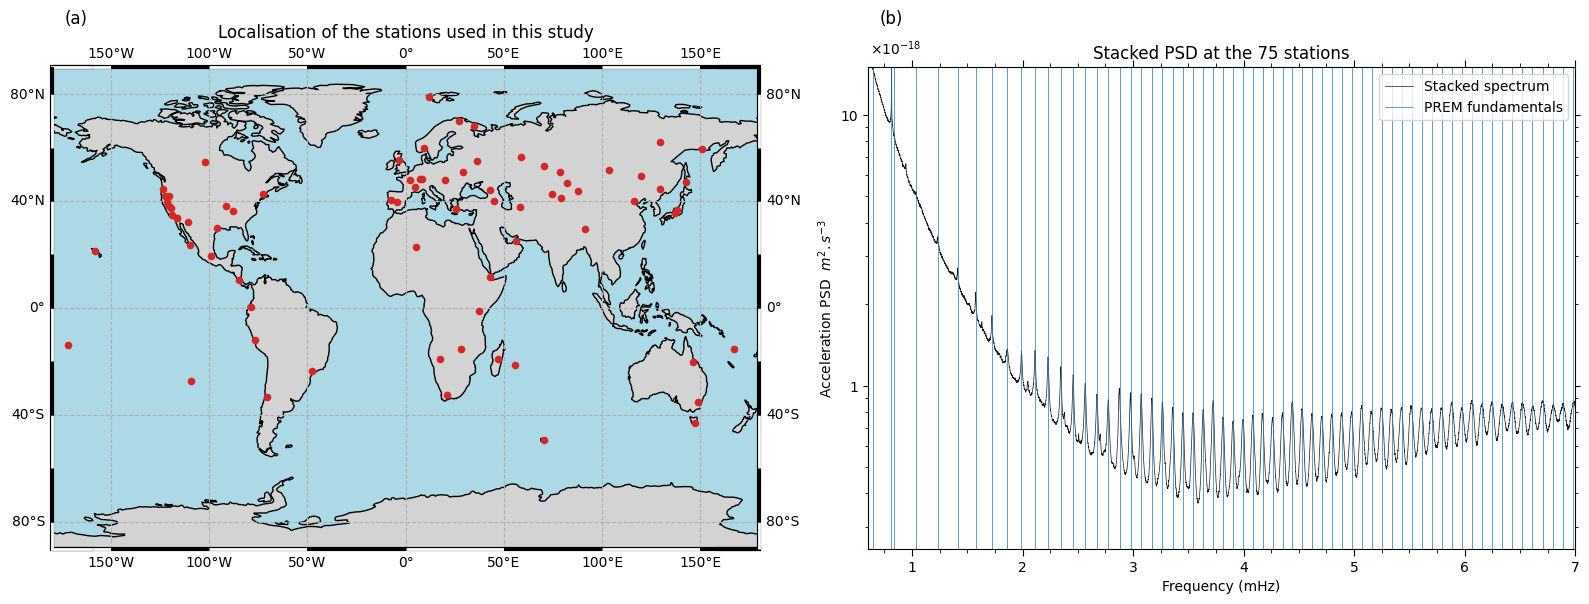

In [ ]:
psd_stacked= np.load('InversionData/FinalResult_75.npy')
station_used= np.load('InversionData/station_used.npy')
coordinates_used= np.load('InversionData/coordinates_used.npy')
nb_station_used= len(station_used)
len2=2**16
freqs= np.fft.fftfreq(2*len2-1, d=10)
plotMapSpectrum(coordinates_used, station_used, psd_stacked, freqs)


## Single core processing of source spectra inversion using the stacked spectrum (~1-2 minutes)

In [5]:
psd_stacked[np.where((freqs > 0.7e-3) & (freqs < 0.91e-3))] = 0 #Mute 0S0 for stability

freqs = np.fft.fftfreq(2 * len2 - 1, d=10)  # d=10 for sampling rate of 10s
freqStart, freqEnd = 0.91e-3, 5e-3
#freqStart, freqEnd = 3e-3, 5e-3

Freqs = getPeakFrequencySeveralModes('InversionData/Smode.out', ['0', '1', '2'], freqStart * 1e3, freqEnd * 1e3)
Freqs= np.linspace(freqStart,freqEnd,200)
bandWidth = 1e-3
alpha_dict2, beta_dict2, freq_dict = {}, {}, {}

# **Parallel Execution**
# loop over the bandwidths, HERE ONLY ONE BANDWIDTH
results=[]


# Compute frequency bands
freqBands=GetFreqBands(freqs, Freqs,bandWidth) #Add freqs
for i,band in enumerate(freqBands):
    if i % 50 == 0:
        print(f"Processing band {i}/{len(freqBands)}")

    result = optimize_psd(band, freqs, psd_stacked, len2) # Function to optimize PSD
    
    results.append(result)  # Collect results
    
# Process results
i=0
alphas, betas,CenterFreqs = [], [], []
for freq,alpha,beta, n1, n2 in results:
    if alpha is not None and beta is not None:
        alphas.append(alpha)
        betas.append(beta)
        CenterFreqs.append(Freqs[i])
    i+=1
alpha_dict2[f"{bandWidth}"] = alphas
beta_dict2[f"{bandWidth}"] = betas
freq_dict[f"{bandWidth}"] = CenterFreqs
print("100% DONE")

alpha_interp, Beta_interp, freqs_interp, CenterFreqs,meanAlpha,meanBeta,stdAlpha,stdBeta = meanAndInterpResults(alpha_dict2, beta_dict2, freq_dict, [bandWidth],freqs)

#np.save('alpha_interp.npy',alpha_interp)
#np.save('Beta_interp.npy',Beta_interp)
#np.save('freqs_interp.npy',freqs_interp)
#np.save('CenterFreqs.npy',CenterFreqs)
#np.save('meanAlpha.npy',meanAlpha)
#np.save('meanBeta.npy',meanBeta)
#np.save('stdAlpha.npy',stdAlpha)
#np.save('stdBeta.npy',stdBeta)
#alpha_interp=np.load('alpha_interpBFGS.npy')
#Beta_interp=np.load('Beta_interpBFGS.npy')
#freqs_interp=np.load('freqs_interpBFGS.npy')
#CenterFreqs=np.load('CenterFreqsBFGS.npy')
#meanAlpha=np.load('meanAlphaBFGS.npy')
#meanBeta=np.load('meanBetaBFGS.npy')
#stdAlpha=np.load('stdAlphaBFGS.npy')
#stdBeta=np.load('stdBetaBFGS.npy')      


Processing band 0/200
Processing band 50/200
Processing band 100/200
Processing band 150/200
100% DONE


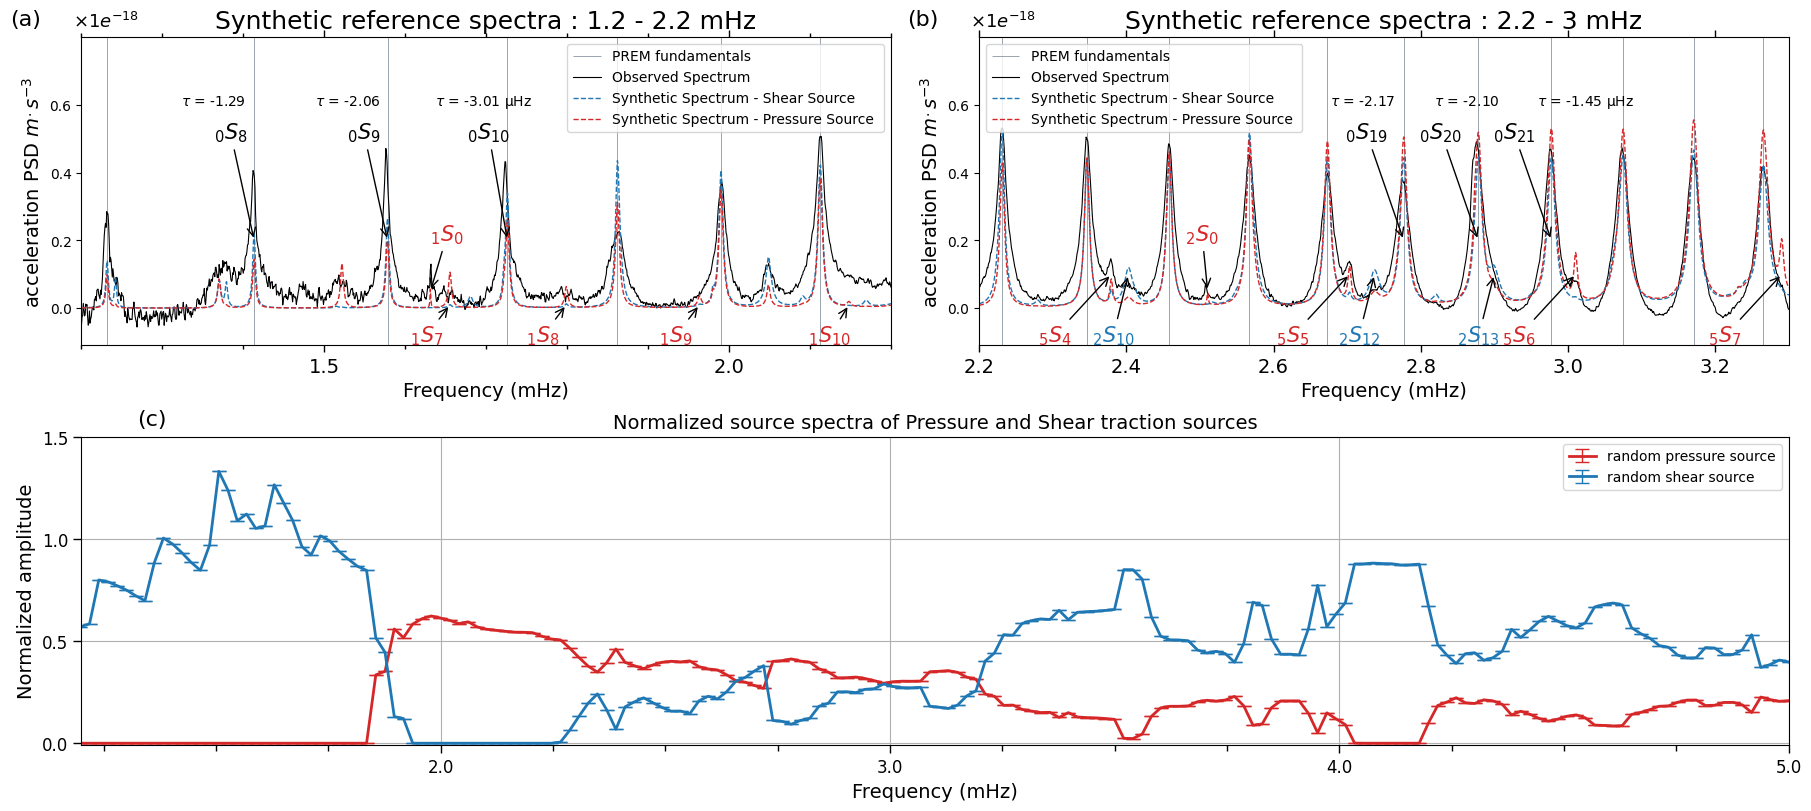

In [10]:
CenterFreqs = np.array(CenterFreqs)
total_synt_atm = 0.9*syntheticPSD_atm
total_synt_oc = 1.5*syntheticPSD_oc
total_spectrum_atm= psd_stacked[freq_mask]*2-6E-18*(freqs[freq_mask]/1E-3)**-2.3+7.6E-19-2.5E-19*(freqs[freq_mask]/1E-3)
ax1,ax2,ax3=plotResults(freqs, total_spectrum_atm, total_synt_atm, total_synt_oc, CenterFreqs, meanAlpha, meanBeta, stdAlpha, stdBeta)

filepath = 'InversionData/Smode.out'
modes=read_modes(filepath,'0')
modes2=read_modes(filepath,'2')
i=0
fundamentals={}
overtones_oc = ['2S10','2S12','2S13']
overtones_atm =['5S4','5S5','5S6','5S7']
overtones_atm2=['1S7','1S8','1S9','1S10','1S11']
for mode in modes:
    n= mode.split('S')[0]
    if n=='0':
        order=mode.split('S')[1]
        if int(order)<3:continue
        if int(order)>50 :
            break
        freq=modes[mode][0]
        #if freq<2.2E-3 or freq>3E-3:continue
        #Create a 0,01 mHz window around the fundamental frequency and get the frequency of the maximum
        window=0.08*1E-3
        freq_min=freq-window/2
        freq_max=freq+window/2
        #print(freq_min,freq_max)
        
        max_freq=freqs[(freqs>=freq_min) & (freqs<=freq_max)][np.argmax(psd_stacked[(freqs>=freq_min) & (freqs<=freq_max)])]
        diff = (max_freq-freq)*1e6 # uHz
        
        if int(order) in [8,9,10,19,20,21]:
            if int(order) in [19,20,21]:
                i+=1
            ax1.annotate(r'$_0S_{'+order+'}$', xy=(freq*1e3, 0.2), xytext=(freq*1e3-0.05, 0.5),
                    fontsize=15, arrowprops=dict(facecolor='black', arrowstyle='->'))
            # Plot the time shift value at top of the annotate text
            if int(order)  in [8,9,10]:
                ax1.text(freq*1e3-0.09, 0.6, r'$\tau$ = 'f'{diff:.2f}', fontsize=10, color='black') if int(order) in [8,9] else ax1.text(freq*1e3-0.09, 0.6, r'$\tau$ = ' f'{diff:.2f} μHz', fontsize=10, color='black')
            else:
                ax2.text(freq*1e3-0.14 + 0.04*i, 0.6, r'$\tau$ = ' f'{diff:.2f}', fontsize=10, color='black')  if int(order) in [19,20] else ax2.text(freq*1e3-0.14 + 0.04*i, 0.6, r'$\tau$ = ' f'{diff:.2f} μHz', fontsize=10, color='black')
            ax2.annotate(r'$_0S_{'+order+'}$', xy=(freq*1e3, 0.2), xytext=(freq*1e3-0.08, 0.5),
                    fontsize=15, arrowprops=dict(facecolor='black', arrowstyle='->'))
            
            
            
for mode in modes2:     
    freq=modes2[mode][0]
    order=mode.split('S')[1]
    #print(mode)
    if mode in overtones_oc:
        
        # Plot the arrow for the overtones
        ax1.annotate(r'$_2S_{'+order+'}$', xy=(freq*1e3, 0.1), xytext=(freq*1e3-0.05, -.1),
                fontsize=15, arrowprops=dict(facecolor='black', arrowstyle='->'),color='tab:blue')
        ax2.annotate(r'$_2S_{'+order+'}$', xy=(freq*1e3, 0.1), xytext=(freq*1e3-0.05, -.1),
                fontsize=15, arrowprops=dict(facecolor='black', arrowstyle='->'),color='tab:blue')
            

mode5=read_modes(filepath,'5')

for mode in mode5:
    freq=mode5[mode][0]
    order=mode.split('S')[1]
    if freq<2.2E-3:continue
    if mode in overtones_atm:
            
        ax2.annotate(r'$_5S_{'+order+'}$', xy=(freq*1e3 , 0.1), xytext=(freq*1e3-0.1, -.1),
                    fontsize=15, arrowprops=dict(facecolor='black', arrowstyle='->'),color='tab:red')
            
modes1=read_modes(filepath,'1')

for mode in modes1:
    freq=modes1[mode][0]
    order=mode.split('S')[1]
    if freq>2.3E-3:continue
    if mode in overtones_atm2:
        ax1.annotate(r'$_1S_{'+order+'}$', xy=(freq*1e3 , 0.01), xytext=(freq*1e3-0.05, -.1),
                fontsize=15, arrowprops=dict(facecolor='black', arrowstyle='->'),color='tab:red')

ax3.set_ylim(-0.01,1.5)        
plt.savefig('Figures/SourceSpectra.png', dpi=300, bbox_inches='tight')
plt.show()